In [1]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

input_data_raw =  pd.read_csv('../rnap_scanned_over_ecoli_genome50k.csv')
sequences = input_data_raw['seq'].tolist()

In [2]:
input_data_raw.head()

,Unnamed: 0,val,seq,left,right,ori,contig
0,0,23.9083,CTATTACCTGCCCACGGTAAAGGCGTTCTGGTTGCCCTACG,3695629,3695669,+,MG1655.fa
1,1,23.5831,TTTCTGCCCGCGGCCTGGCAATTGATACCGCCTTGCCATCG,1109059,1109099,+,MG1655.fa
2,2,23.4205,TTTTTACACGCCTTGCGTAAAGCGGCACGGCGCGGGGTGCG,822216,822256,-,MG1655.fa
3,3,23.4098,TTGCTGCCTGGCCGATGGTCTATGCCGCTGCGTTCTCCGGC,772478,772518,+,MG1655.fa
4,4,23.3640,CTTTTACACGCAAAATGCCGTCACGTTCACGGGTCTGGGCT,2748531,2748571,+,MG1655.fa


## Make positive and negative Labels

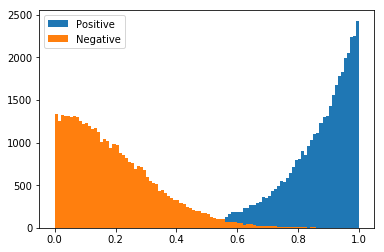

0.0

In [3]:
num_sample = 40000   # number of training samples
test_size = 10000    # number of test samples

# positive and negative labels
# normalize the following between 0 and 1
pos_labels = np.array(input_data_raw['val'][0:num_sample])
pos_labels = 1-(pos_labels-min(pos_labels))/(max(pos_labels)-min(pos_labels))
neg_labels = abs(0.05*np.random.randn(num_sample,))
#pos_labels = 1-neg_labels
neg_labels = (neg_labels-min(neg_labels))/(max(neg_labels)-min(neg_labels))


# test positive and negative labels
test_pos_labels = np.array(input_data_raw['val'][num_sample:num_sample+test_size])
test_pos_labels = 1-(test_pos_labels-min(test_pos_labels))/(max(test_pos_labels)-min(test_pos_labels))
test_neg_labels = abs(0.05*np.random.randn(test_size,))
test_neg_labels = (test_neg_labels-min(test_neg_labels))/(max(test_neg_labels)-min(test_neg_labels))

plt.hist(pos_labels,bins=100,label='Positive')
plt.hist(neg_labels,bins=100,label='Negative')
plt.legend()
plt.show()
# assigned random values to negative examples

pos_labels[0]

## Collect positive and negative samples

In [4]:
pos = []

test_pos = []

for index in range(len(sequences[0:num_sample])):
    pos.append(list(sequences[index]))
    
for test_index in range(len(sequences[num_sample:num_sample+test_size])):
    test_pos.append(list(sequences[test_index]))    

pos = np.array(pos)
test_pos = np.array(test_pos)

seq_length = len(pos[0])

neg = np.array([np.random.choice(['A', 'C', 'G', 'T'], num_sample, p=np.array([1,1,1,1])/4.0)
                for i in range(seq_length)]).transpose()

#[''.join(x) for x in neg[1:10,:]]

test_neg = np.array([np.random.choice(['A', 'C', 'G', 'T'], test_size, p=np.array([1,1,1,1])/4.0)
                for i in range(seq_length)]).transpose()

## One-hot encoding

In [5]:
pos_tensor = np.zeros(list(pos.shape) + [4])
neg_tensor = np.zeros(list(neg.shape) + [4])

test_pos_tensor = np.zeros(list(test_pos.shape) + [4])
test_neg_tensor = np.zeros(list(test_neg.shape) + [4])

base_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

#naive one-hot encoding
for row in range(num_sample):
    for col in range(seq_length):
        pos_tensor[row,col,base_dict[pos[row,col]]] = 1
        neg_tensor[row,col,base_dict[neg[row,col]]] = 1
        if(row<test_size):
            test_pos_tensor[row,col,base_dict[test_pos[row,col]]] = 1
            test_neg_tensor[row,col,base_dict[test_neg[row,col]]] = 1        

print('Positive sample matrix shape: {}'.format(pos.shape))
# this should be a 3D tensor with shape: (samples, steps, input_dim)
print('Positive sample tensor shape: {}'.format(pos_tensor.shape))

X = np.vstack((pos_tensor, neg_tensor))
#X = pos_tensor
#y = np.concatenate((np.ones(num_sample), np.zeros(num_sample)))
y = np.concatenate([pos_labels, neg_labels])
#y = pos_labels

#X_test = test_pos_tensor
#y_test = test_pos_labels


X_test = np.vstack((test_pos_tensor, test_neg_tensor))
y_test = np.concatenate([test_pos_labels, test_neg_labels])

print('Training set shape: {}'.format(X.shape))
print('Training set label shape: {}'.format(y.shape))
print('\nOne-hot encoding looks like:\n {}'.format(X[0,0:10,:]))

Positive sample matrix shape: (40000, 41)
Positive sample tensor shape: (40000, 41, 4)
Training set shape: (80000, 41, 4)
Training set label shape: (80000,)

One-hot encoding looks like:
 [[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


# Define error metrics

In [6]:
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

## Define Models

In [7]:
#here comes the deep learning part
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, Dropout
from keras.activations import relu
from keras.layers.pooling import MaxPooling1D
from keras.optimizers import SGD, Adam

#sanity check for dimensions
#print('Shape of the output of first layer: {}'.format(model.predict_on_batch(pos_tensor[0:1,:,:]).shape))

Using TensorFlow backend.


In [8]:

model = Sequential()
#model.add(Conv1D(1, 19, padding='same', input_shape=(seq_length, 4), activation='relu'))
model.add(Conv1D(10, 41, padding='same', input_shape=(seq_length, 4), activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(10, 20, padding='same', input_shape=(seq_length, 4), activation='relu'))
#model.add(Dropout(0.75))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.25))
#model.add(Dense(1, activation='sigmoid'))
model.add(Dense(1, activation='linear'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])
#model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

#model.compile(loss='mean_squared_error',optimizer='adam', metrics=['mean_squared_error',r_square])
model.compile(loss='mean_squared_error',optimizer=Adam(lr=0.0001), metrics=[rmse])
#model.compile(loss='mean_squared_error',optimizer=sgd, metrics=[rmse])

#history = model.fit(X, y, validation_split=0.2, epochs=50)  # starts training
history = model.fit(X, y, validation_split=0.3, epochs=75,batch_size=5000)  # starts training



Train on 56000 samples, validate on 24000 samples
Epoch 1/75
56000/56000 [==============================] - 3s 60us/step - loss: 0.3722 - rmse: 0.5351 - val_loss: 0.0246 - val_rmse: 0.1309
Epoch 2/75
56000/56000 [==============================] - 3s 56us/step - loss: 0.2558 - rmse: 0.4452 - val_loss: 0.0698 - val_rmse: 0.2364
Epoch 3/75
56000/56000 [==============================] - 3s 54us/step - loss: 0.1742 - rmse: 0.3650 - val_loss: 0.1748 - val_rmse: 0.3926
Epoch 4/75
56000/56000 [==============================] - 3s 54us/step - loss: 0.1493 - rmse: 0.3240 - val_loss: 0.2483 - val_rmse: 0.4753
Epoch 5/75
56000/56000 [==============================] - 3s 54us/step - loss: 0.1459 - rmse: 0.3157 - val_loss: 0.2223 - val_rmse: 0.4475
Epoch 6/75
56000/56000 [==============================] - 3s 55us/step - loss: 0.1401 - rmse: 0.3153 - val_loss: 0.1922 - val_rmse: 0.4132
Epoch 7/75
56000/56000 [==============================] - 3s 54us/step - loss: 0.1367 - rmse: 0.3137 - val_loss: 0.1

56000/56000 [==============================] - 3s 58us/step - loss: 0.0684 - rmse: 0.2096 - val_loss: 0.0755 - val_rmse: 0.2187
Epoch 60/75
56000/56000 [==============================] - 3s 56us/step - loss: 0.0675 - rmse: 0.2078 - val_loss: 0.0735 - val_rmse: 0.2148
Epoch 61/75
56000/56000 [==============================] - 3s 55us/step - loss: 0.0666 - rmse: 0.2060 - val_loss: 0.0730 - val_rmse: 0.2134
Epoch 62/75
56000/56000 [==============================] - 3s 54us/step - loss: 0.0658 - rmse: 0.2048 - val_loss: 0.0723 - val_rmse: 0.2119
Epoch 63/75
56000/56000 [==============================] - 3s 59us/step - loss: 0.0654 - rmse: 0.2041 - val_loss: 0.0708 - val_rmse: 0.2087
Epoch 64/75
56000/56000 [==============================] - 3s 54us/step - loss: 0.0648 - rmse: 0.2032 - val_loss: 0.0683 - val_rmse: 0.2042
Epoch 65/75
56000/56000 [==============================] - 3s 54us/step - loss: 0.0638 - rmse: 0.2007 - val_loss: 0.0679 - val_rmse: 0.2030
Epoch 66/75
56000/56000 [=======

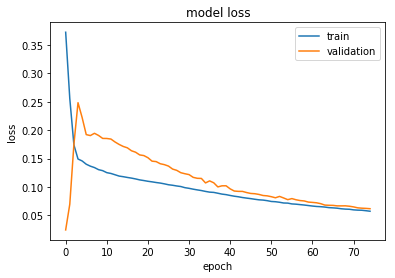

In [9]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [10]:
history.history.keys()

dict_keys(['val_loss', 'val_rmse', 'loss', 'rmse'])

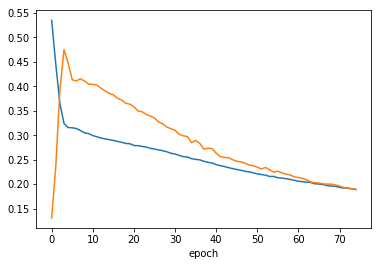

In [11]:
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
#plt.title('model R^2')
#plt.ylabel('R^2')
plt.xlabel('epoch')
#plt.legend(['val_r_sq', 'r_sq'], loc='upper left')
plt.show()


In [12]:
#have a look at the filter
convlayer = model.layers[0]
weights = convlayer.get_weights()[0].squeeze()
print('Convolution parameter shape: {}'.format(weights.shape))

#num2seq = ['A','C','G','T']

#''.join([num2seq[np.argmax(weights[i,:])] for i in range(weights.shape[0])])
#test_pred = ''.join([num2seq[np.argmax(weights[i,:])] for i in range(weights.shape[0])])

Convolution parameter shape: (41, 4, 10)


## Make predictions

In [13]:
model_prediction = model.predict(X_test)

In [14]:
np.shape(X_test)

(20000, 41, 4)

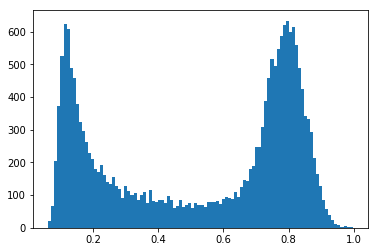

In [15]:
plt.hist(model_prediction,bins=100)
plt.show()

In [16]:
#''.join([num2seq[np.argmax(weights[i,:])] for i in range(weights.shape[0])])
weights[5,:]

array([[-0.02612495, -0.06943432, -0.0026543 ,  0.10064758,  0.09841388,
         0.08076848, -0.02388658,  0.06202935, -0.00040936,  0.03594155],
       [-0.09794176,  0.00358265, -0.07521181,  0.1319097 ,  0.08342429,
         0.00309151,  0.01641043, -0.00446339, -0.00104466,  0.09556536],
       [ 0.1504708 ,  0.05519286,  0.06018589,  0.01006542, -0.06158207,
         0.05451148, -0.08120733, -0.07498855, -0.01525173, -0.0380404 ],
       [ 0.04279283, -0.0980147 , -0.06995706, -0.11999162, -0.03191054,
         0.01733819,  0.05379084, -0.0649472 , -0.02801137,  0.10849223]],
      dtype=float32)

In [17]:
np.argmax(weights[5,:])

20

In [18]:
top_logo_chars = ['C','T','A','C','T','A','C','A','C','G',
                  'C','C','C','C','A','T','A','T','T','G',
                  'A','G','C','G','A','T','C','C','C','G',
                  'G','G','T','T','C','C','C','C','C','C',
                  'G']